(2284, 240, 320, 3)
(2284, 60, 80)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/300
183/183 [==============================] - 26s 110ms/step - loss: 5.6170 - accuracy: 0.0140 - val_loss: 1.4573 - val_accuracy: 0.0140
Epoch 2/300
183/183 [==============================] - 19s 102ms/step - loss: 4.9325 - accuracy: 0.0157 - val_loss: 1.6375 - val_accuracy: 0.0126
Epoch 3/300
183/183 [==============================] - 19s 103ms/step - loss: 3.9658 - accuracy: 0.0157 - val_loss: 0.8755 - val_accuracy: 0.0150
Epoch 4/300
183/183 [==============================] - 19s 102ms/step - loss: 3.4164 - accuracy: 0.0159 - val_loss: 0.8299 - val_accuracy: 0.0142
Epoch 5/300
183/183 [==============================] - 19s 101ms/step - loss: 3.2107 - accuracy: 0.0163 - val_loss: 0.8997 - val_accuracy: 0.0144
Epoch 6/300
183/183 [==============================] - 19s 102ms/step - loss: 3.0185 - accuracy: 0.0162 - val_loss: 0.7227 - val_accuracy: 0.0150
Epoch 7/300
183/183 [==============================] - 19s 101ms/step - loss: 2.8645 - accuracy: 0.0169 - val_loss: 1.3177 -

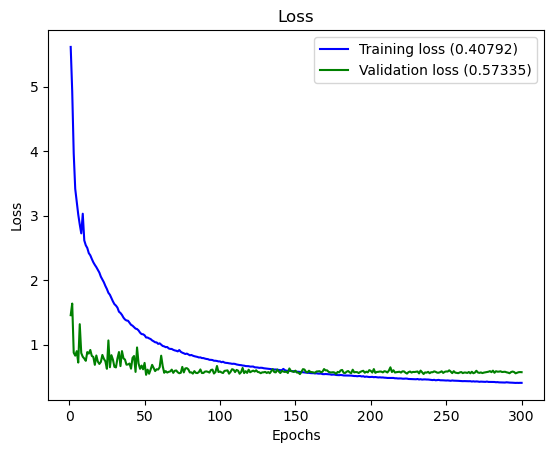

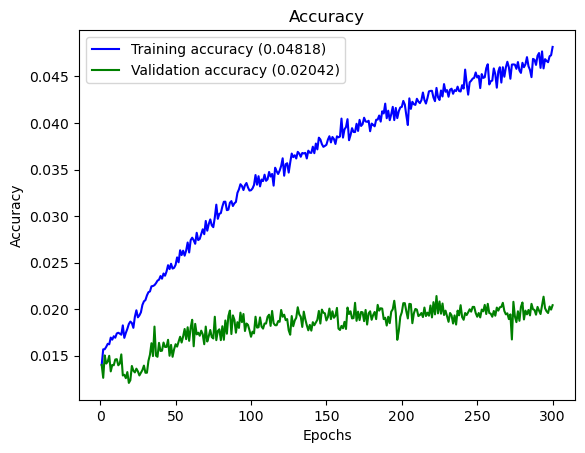

NameError: name 'X_train' is not defined

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
import tensorflow.keras as keras
import tensorflow as tf
'''
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
'''
tf.config.run_functions_eagerly(True)
import os
import matplotlib.pyplot as plt
import sklearn
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
# (2284, 320, 240, 3)
# (2284, 640, 480)
# (2284, 640, 480)

def import_data():
    npzfile = np.load('/kaggle/input/nyu-depth-v1/input_data.npy')
    data_depth = npzfile['x']
    data_images = npzfile['y']
    return data_depth,data_images
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
keras.backend.set_floatx('float32')


epoch_ = 300
batch_size_ = 10
coarse_lrate = 0.01
fine_lrate = 0.001
# (2284, 320, 240, 3)
# (2284, 640, 480)
# (2284, 640, 480)
lambda_ = 0.5
cutoff = 2284

def coarse_nn(X,Y):
    print(X.shape)
    print(Y.shape)

    model = keras.models.Sequential() 
    
    # input was downsampled from the original by a factor of 2
    model.add(keras.layers.InputLayer(input_shape=(240,320,3)))
    model.add(keras.layers.Conv2D(96,(11,11),strides = (4,4),activation= 'relu',input_shape =(240,320,1),padding='same'))
    model.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
    model.add(keras.layers.Conv2D(256,(5,5),activation= 'relu',padding='same'))
    model.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
    model.add(keras.layers.Conv2D(384,(3,3),activation= 'relu',padding='same'))
    model.add(keras.layers.Conv2D(384,(3,3),activation= 'relu',padding='same'))
    model.add(keras.layers.Conv2D(384,(3,3),activation= 'relu',padding='same'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(4096,activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(4800,activation='relu')) # output at 1/4 resolution of input
    model.add(keras.layers.Reshape((60,80)))
    
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=coarse_lrate),loss = Scale_invariant_loss,metrics = ['accuracy'])
    #model.compile(optimizer = tf.keras.optimizers.Adam(),loss = Scale_invariant_loss,metrics = ['accuracy'])

    history = model.fit(x = X,y = Y, epochs = epoch_,batch_size = batch_size_, validation_split=0.2)
    #coarse_output = model.predict(X)
    #model.save("my_coarse_model")
    #print("Model Saved")
    plot_history(history)
    return model


    
def Scale_invariant_loss(y_true, y_pred):
    #tf.print("\ny_true",y_true.shape)
    #tf.print("y_pred",y_pred.shape)
    
    #y_pred = tf.clip_by_value(y_pred,0,y_pred.dtype.max)
    #tf.print("y_pred_max",keras.backend.max(y_pred))
    #tf.print("y_pred_min",keras.backend.min(y_pred))
    #log_y_true = keras.backend.log(y_true+keras.backend.epsilon())
    #log_y_pred = keras.backend.log(y_pred+keras.backend.epsilon())

    diff = y_pred - y_true  
    #tf.print("diff_max",keras.backend.max(diff))
    #tf.print("diff_min",keras.backend.min(diff))
    n = y_true.shape[1] * y_true.shape[2]
    
    squared_diff = keras.backend.square(diff)
    #tf.print("squared_diff_max",keras.backend.max(squared_diff))
    #tf.print("squared_diff_min",keras.backend.min(squared_diff))
    
    loss_term1 = tf.math.reduce_mean(squared_diff,[1,2])
    #tf.print("loss_term1",loss_term1.shape)
    #tf.print("loss_term1_max",keras.backend.max(loss_term1))
    #tf.print("loss_term1_min",keras.backend.min(loss_term1))
    
    loss_term2 = tf.math.reduce_sum(diff,[1,2])
    #tf.print("Reduced_sum",loss_term2)
    loss_term2 = keras.backend.square(loss_term2)
    #tf.print("Reduced_sum_squared",loss_term2)

    loss_term2 = 0.5*loss_term2/(n**2)
    #tf.print("loss_term2",loss_term2.shape)
    #tf.print("loss_term2_max",keras.backend.max(loss_term2))
    #tf.print("loss_term2_min",keras.backend.min(loss_term2))
    
    loss = loss_term1 - loss_term2
    #tf.print("per_sample_loss",loss)
    loss = tf.math.reduce_mean(loss)
    #tf.print("total_loss_mean",loss)
    return loss



def load_coarse():
    model = keras.models.load_model("my_coarse_model", compile = False)
    return model

def visualize_depth_map(samples):
    image, target,pred = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")


    fig, ax = plt.subplots(3, 3, figsize=(50, 50))
    for i in range(3):
        
        
        ax[i, 0].imshow((image[i*10].squeeze()))
        ax[i, 1].imshow((target[i*10].squeeze()), cmap=cmap)
        ax[i, 2].imshow((pred[i*10].squeeze()), cmap=cmap)
    plt.show()


def model_predict(model,X):
    y = model.predict(X)
    
    return y
def plot_fine(fine_model,data_depth,data_images):    
    fine_prediction = model_predict(fine_model,data_images)
    visualize_depth_map((data_images,data_depth,fine_prediction))

    return
def plot_coarse(coarse_model,data_depth,data_images):
    #coarse_model = load_coarse()

    coarse_prediction = model_predict(coarse_model,data_images)
    visualize_depth_map((data_images,data_depth,coarse_prediction))

    return

data_depth,data_images = import_data()
data_images = np.divide(data_images, 255)

data_images = np.array([cv2.rotate(i,cv2.ROTATE_90_CLOCKWISE) for i in data_images])
data_depth = np.array([cv2.rotate(i,cv2.ROTATE_90_CLOCKWISE) for i in data_depth])
#X_train, X_test, y_train, y_test = train_test_split(data_images, data_depth, test_size=0.20, random_state=42)

coarse_model = coarse_output = coarse_nn(data_images,data_depth)
plot_coarse(coarse_model,X_train[:100],data_depth[:100])
    


In [ ]:
'''
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
keras.backend.set_floatx('float32')

def import_data():
    npzfile = np.load('/kaggle/input/nyu-depth-v1/input_data.npy')
    data_depth = npzfile['x']
    data_images = npzfile['y']
    return data_depth,data_images

def visualize_depth_map(samples):
    image, target,pred = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")


    fig, ax = plt.subplots(3, 3, figsize=(50, 50))
    for i in range(3):
        
        
        ax[i, 0].imshow((image[i*10].squeeze()))
        ax[i, 1].imshow((target[i*10].squeeze()), cmap=cmap)
        ax[i, 2].imshow((pred[i*10].squeeze()), cmap=cmap)
    plt.show()


def model_predict(model,X):
    y = model.predict(X)
    
    return y
def plot_fine(fine_model,data_depth,data_images):    
    fine_prediction = model_predict(fine_model,data_images)
    visualize_depth_map((data_images,data_depth,fine_prediction))

    return
'''
def fine_net(X,Y,coarse_model):
    input_1 = keras.layers.Input(shape=(240,320,3))
    layer_1_1 = keras.layers.Conv2D(96,(11,11),strides = (4,4),activation= 'relu',input_shape =(240,320,1),padding='same')(input_1)
    layer_1_2 = keras.layers.MaxPooling2D(pool_size = (2,2))(layer_1_1)
    layer_1_3 = keras.layers.Conv2D(256,(5,5),activation= 'relu',padding='same')(layer_1_2)
    layer_1_4 = keras.layers.MaxPooling2D(pool_size = (2,2))(layer_1_3)
    layer_1_5 = keras.layers.Conv2D(384,(3,3),activation= 'relu',padding='same')(layer_1_4) 
    layer_1_6 = keras.layers.Conv2D(384,(3,3),activation= 'relu',padding='same')(layer_1_5)
    layer_1_7 = keras.layers.Conv2D(384,(3,3),activation= 'relu',padding='same')(layer_1_6)
    layer_1_8 = keras.layers.Flatten()(layer_1_7)  
    layer_1_9 = keras.layers.Dense(4096,activation='relu')(layer_1_8)
    layer_1_10 = keras.layers.Dropout(0.5)(layer_1_9)
    layer_1_11 = keras.layers.Dense(4800,activation='relu')(layer_1_10)
    layer_1_12 = keras.layers.Reshape((60,80,1))(layer_1_11)
    layer_2_1 = keras.layers.Conv2D(63,(9,9),activation= 'relu',input_shape =(320,240,1),padding='same')(input_1)
    layer_2_2 = keras.layers.MaxPooling2D(pool_size = (2,2),strides = 4)(layer_2_1)
    layer_2_3 = keras.layers.Concatenate()([layer_1_12,layer_2_2])
    layer_2_4 = keras.layers.Conv2D(64,(5,5),activation= 'relu',padding='same')(layer_2_3)
    layer_2_5 = keras.layers.Conv2D(1,(5,5),activation= 'relu',padding='same')(layer_2_4)
    model = keras.Model(inputs = [input_1],outputs = [layer_2_5])
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = fine_lrate),loss = Scale_invariant_loss,metrics = ['accuracy'])
    model.layers[1].trainable = False
    model.layers[3].trainable = False
    model.layers[5].trainable = False
    model.layers[6].trainable = False
    model.layers[7].trainable = False
    model.layers[9].trainable = False
    model.layers[11].trainable = False
    model.layers[1].set_weights(coarse_model.layers[0].get_weights())
    model.layers[3].set_weights(coarse_model.layers[2].get_weights())
    model.layers[5].set_weights(coarse_model.layers[4].get_weights())
    model.layers[6].set_weights(coarse_model.layers[5].get_weights())
    model.layers[7].set_weights(coarse_model.layers[6].get_weights())
    model.layers[9].set_weights(coarse_model.layers[8].get_weights())
    model.layers[11].set_weights(coarse_model.layers[10].get_weights())
    print(model.summary(show_trainable = True,expand_nested = True))
    
    
    
    model.fit(x = X,y = Y, epochs = 200 ,batch_size = 1)
    
    
    #model.save("my_fine_model")
    return model


'''
data_depth,data_images = import_data()
data
data_images = np.divide(data_images, 255)
data_images = np.array([cv2.rotate(i,cv2.ROTATE_90_CLOCKWISE) for i in data_images])
data_depth = np.array([cv2.rotate(i,cv2.ROTATE_90_CLOCKWISE) for i in data_depth])
'''
#coarse_model = keras.models.load_model("my_coarse_model", compile = False)
data_images = np.float32(data_images)
#data_images = data_images[0]
#data_depth = data_depth[0]
fine_model = fine_net(data_images,data_depth,coarse_model)
plot_fine(fine_model,data_depth[:100],data_images[:100])


In [ ]:
#coarse_model.save("my_coarse_model")

In [13]:
from pynvml.smi import nvidia_smi
print(f"Free GPU memory - {nvidia_smi.getInstance().DeviceQuery('memory.total')}")
print(f"Used GPU memory - {nvidia_smi.getInstance().DeviceQuery('memory.used')}")

Free GPU memory - {'gpu': [{'fb_memory_usage': {'total': 16280.875, 'unit': 'MiB'}}]}
Used GPU memory - {'gpu': [{'fb_memory_usage': {'used': 16067.125, 'unit': 'MiB'}}]}
